## Employing a Multi-target regression (MTR) strategy for predicting horizon-based time series modelling

### Highlights:

- In this notebook I will present some initial experiments using MTR to model horizon forescating for the S\&P 500 dataset
- The 3M time series was considered
- A traditional MTR (Stacked Single-target) method was employed to generate the predictions
- LASSO, Elastic Net, Support Vector Regression, and Random Forest were employed as regression techniques:
    - Random Forest was selected as the best performer

### Let's go to the tests:

#### Firstly, the imports

In [1]:
# Imports
import pandas as pd # Data manipulation
import numpy as np # Algebric operations
import matplotlib.pyplot as plt # Plots
from sklearn.ensemble import RandomForestRegressor # RF regressor
from mtr_time_series import MTRTimeSeries # Golden eggs chicken
import sys
sys.path.append('../')
from utils import hit_count

#### Data reading

In [2]:
# Read the data
data = pd.read_csv('../../Data/all_stocks_5yr.csv')
data.head(5)

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


### All the actives

In [3]:
# All actives
' '.join(np.unique(data.loc[:, 'Name']).tolist())

'A AAL AAP AAPL ABBV ABC ABT ACN ADBE ADI ADM ADP ADS ADSK AEE AEP AES AET AFL AGN AIG AIV AIZ AJG AKAM ALB ALGN ALK ALL ALLE ALXN AMAT AMD AME AMG AMGN AMP AMZN ANDV ANSS ANTM AON AOS APA APC APD APH ARE ARNC ATVI AVB AVGO AVY AWK AXP AYI AZO BA BAC BAX BBT BBY BCR BDX BEN BF.B BHF BHGE BIIB BK BLK BLL BMY BRK.B BSX BWA BXP C CA CAG CAH CAT CB CBG CBOE CBS CCI CCL CELG CERN CF CFG CHD CHK CHRW CHTR CI CINF CL CLX CMA CMCSA CME CMG CMI CMS CNC CNP COF COG COH COL COO COP COST COTY CPB CRM CSCO CSRA CSX CTAS CTL CTSH CTXS CVS CVX CXO D DAL DD DE DFS DG DGX DHI DHR DIS DISCA DISCK DISH DLPH DLR DLTR DOV DOW DPS DRE DRI DTE DUK DVA DVN DXC EA EBAY ECL ED EFX EIX EL EMN EMR EOG EQIX EQR EQT ES ESRX ESS ETFC ETN ETR EVHC EW EXC EXPD EXPE EXR F FAST FB FBHS FCX FDX FE FFIV FIS FISV FITB FL FLIR FLR FLS FMC FOX FOXA FRT FTI FTV GD GE GGP GILD GIS GLW GM GOOG GOOGL GPC GPN GPS GRMN GS GT GWW HAL HAS HBAN HBI HCA HCN HCP HD HES HIG HLT HOG HOLX HON HP HPE HPQ HRB HRL HRS HSIC HST HSY HUM IBM IC

### Now I'm going to select a single active to apply the MTR strategy (horizon predicting)

In [4]:
select_actv = 'MMM'

s_data = data[data['Name'] == select_actv]

### Counting the amount of examples for the active

In [5]:
len(s_data)

1258

### Setup time series

#### To this end, only the closing prices were considered

In [6]:
time_serie = s_data['Close'].values.tolist()
time_serie[1:5]

[92.3, 92.54, 93.74, 94.24]

### Create and setup MTR evaluator

In [7]:
mtr_ts = MTRTimeSeries(
    time_serie=time_serie,
    window_size=10,
    horizon_size=5,
    init_buffer_size=200,
    sst_method='predictions'
)

### Set the regressor for the SST method

In [8]:
mtr_ts.set_regressor(RandomForestRegressor, {'n_estimators': 500, 'n_jobs': 6, 'max_features': 'sqrt'})

### Iterate over time serie and get the predictions

In [9]:
predictions = np.array(mtr_ts.iterate_fit_predict())

In [10]:
predictions[1:10]

array([111.07002, 110.817  , 110.56512, 110.28972, 109.9364 , 109.69902,
       110.05718, 110.41644, 111.48898])

### Do the same thing but applying an exponential smoothing

In [11]:
mtr_ts_decay = MTRTimeSeries(
    time_serie=time_serie,
    window_size=10,
    horizon_size=5,
    init_buffer_size=200,
    use_exp_smoothing=True,
    gamma=0.5,
    sst_method='predictions'
)
mtr_ts_decay.set_regressor(RandomForestRegressor, {'n_estimators': 500, 'n_jobs': 6, 'max_features': 'sqrt'})
predictions_decay = np.array(mtr_ts_decay.iterate_fit_predict())

### Next, I will generate some plots of the predicted values:

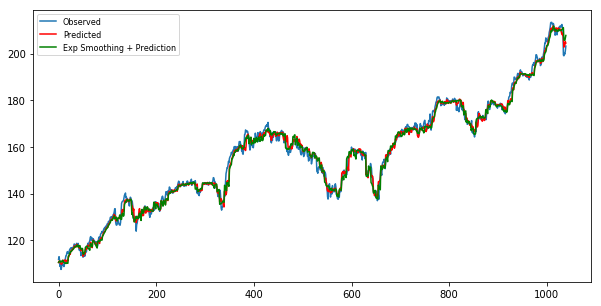

In [12]:
pred_start = mtr_ts.init_prediction_index()
observations = np.array(time_serie[pred_start:(pred_start + len(predictions))])
plt.figure(figsize=(10,5))
plt.plot(observations, label='Observed')
plt.plot(predictions, c='r', label='Predicted')
plt.plot(predictions_decay, c='g', label='Exp Smoothing + Prediction')
plt.legend(fontsize=8)
plt.show()

### Let's define some error functions

In [13]:
def MSE(obs, pred):
    return np.sum((obs - pred) ** 2)/len(obs)

def RMSE(obs, pred):
    return np.sqrt(np.sum((obs - pred) ** 2)/len(obs))

def RRMSE(obs, pred):
    num = np.sum((obs - pred) ** 2) + 1e-6
    den = np.sum((obs - np.mean(obs)) ** 2) + 1e-6
    return np.sqrt(num/den)

### Observed errors

In [14]:
print('MSE: {}'.format(MSE(observations, predictions)))
print('RMSE: {}'.format(RMSE(observations, predictions)))
print('RRMSE: {}'.format(RRMSE(observations, predictions)))
print()
print('MSE-Decay: {}'.format(MSE(observations, predictions_decay)))
print('RMSE-Decay: {}'.format(RMSE(observations, predictions_decay)))
print('RRMSE-Decay: {}'.format(RRMSE(observations, predictions_decay)))

MSE: 3.9539271477367484
RMSE: 1.9884484272257976
RRMSE: 0.08583193461764344

MSE-Decay: 5.063901983859404
RMSE-Decay: 2.250311530401825
RRMSE-Decay: 0.0971353289816542


### Length of the observations

In [15]:
len(observations)

1040

In [17]:
print('Hits (without exp smoothing): {}'.format(hit_count(observations, predictions)))
print('Hits (with exp smoothing): {}'.format(hit_count(observations, predictions_decay)))

Hits (without exp smoothing): 694
Hits (with exp smoothing): 625
